In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score

import matplotlib.pyplot as plt

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
ndim=28

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
input_img = layers.Input(shape=(ndim, ndim, 1))

latent_dim = 128

x=layers.Conv2D(16, kernel_size=3, strides=2, activation='relu', padding='same')(input_img)
x=layers.BatchNormalization()(x)
x=layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='valid')(x)
x=layers.Flatten()(x)
x=layers.Dense(128, activation='relu')(x)
#x=layers.Dense(latent_dim, activation=None)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 16)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 32)     4640        ['batch_normalization[0][0]

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x=layers.Dense(128, activation='relu')(latent_inputs)
x=layers.Dense(3 * 3 * 64, activation='relu')(x)
x=layers.Reshape((3,3,64))(x)
x=layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu", padding="valid")(x)
x=layers.BatchNormalization()(x)
x=layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x=layers.BatchNormalization()(x)
x=layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same')(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 576)               74304     
                                                                 
 reshape (Reshape)           (None, 3, 3, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         18464     
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                           

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data[0])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
epochs=30
batch_size=128

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

epochs=50
batch_size=128
x_train_unlabeled=x_train[:50000].copy()
y_train_unlabeled=y_train[:50000].copy()

x_train_size=x_train_unlabeled.shape[0]

print(f"Train Dataset Size= {x_train_size} images")
hist=vae.fit(x=x_train_unlabeled, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, x_test))

Train Dataset Size= 50000 images
Epoch 1/50
391/391 [==============================] - 6s 7ms/step - loss: 510.9022 - reconstruction_loss: 426.3154 - kl_loss: 0.2202 - val_loss: 245.4486 - val_reconstruction_loss: 243.0888 - val_kl_loss: 2.3598
Epoch 2/50
391/391 [==============================] - 2s 6ms/step - loss: 224.8704 - reconstruction_loss: 207.7492 - kl_loss: 5.1359 - val_loss: 196.8494 - val_reconstruction_loss: 190.2772 - val_kl_loss: 6.5721
Epoch 3/50
391/391 [==============================] - 2s 6ms/step - loss: 193.0884 - reconstruction_loss: 180.8231 - kl_loss: 8.2878 - val_loss: 182.4361 - val_reconstruction_loss: 172.8929 - val_kl_loss: 9.5433
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 180.1866 - reconstruction_loss: 167.8667 - kl_loss: 10.0497 - val_loss: 173.7612 - val_reconstruction_loss: 163.5161 - val_kl_loss: 10.2451
Epoch 5/50
391/391 [==============================] - 2s 6ms/step - loss: 171.0610 - reconstruction_loss: 157.7158 - 

In [9]:
vae.evaluate(x_test, x_test)

313/313 [==============================] - 1s 2ms/step - loss: 105.2814 - reconstruction_loss: 88.6685 - kl_loss: 16.8242


[88.66850280761719, 16.82420539855957, 105.4926986694336]

In [10]:
print(f"Train Loss= {(hist.history['loss'][-1]):.3e}")
print(f"Validation Loss= {(hist.history['val_loss'][-1]):.3e}")

Train Loss= 1.050e+02
Validation Loss= 1.054e+02


[[-1.415037   -1.509167   -0.86690366 -0.4151393   1.0349611   0.20097104
  -0.02821349  1.3819413   0.2521659   0.5459147  -1.8153313  -2.7131786
  -1.4708416   1.0872515  -0.7547989   1.7805854  -2.3761594  -1.1890458
  -0.02098418 -0.57452595 -1.0285443  -0.41635764 -1.4592509   1.0180132
   1.5258387   2.3710363  -1.4736059   0.37645945 -1.3783492   1.6924728
   0.7976362   1.0400289  -0.98589414  1.1259354  -0.6601646  -1.4736128
   0.10427067 -0.5462116  -0.02913175 -1.4072173  -1.2257247  -1.1533364
   0.49802116 -0.6985077   0.9113222  -0.04272223  0.6867949  -0.7312605
   1.921413    0.18393731 -0.3999741   0.5790431  -2.3709583  -1.0737528
  -1.692231    0.7135789   0.5228654  -1.3090241   0.1043039   0.14398704
   0.83084124  0.7725551  -0.7180794   2.0894082   1.2181188   0.2304563
  -0.14391927  0.97588444 -0.01835774  0.232483    0.09723078  0.5358885
  -0.03390358 -0.2989435  -0.2494784  -1.0281092  -1.2741125   0.03031074
  -0.12887013  0.7834153  -1.788528   -0.9782293

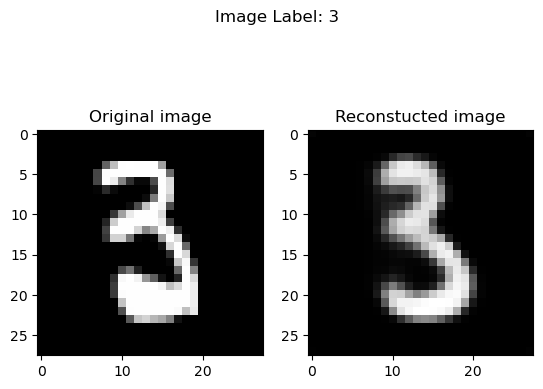

In [11]:
index=50025

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

[[ 2.49303252e-01  1.12160373e+00 -6.13167644e-01  1.59687555e+00
  -1.34590268e+00  1.24835677e-01 -8.35920334e-01 -1.11216009e+00
   2.27109164e-01  5.11308491e-01  1.03964686e+00  2.18236241e-02
   3.74762952e-01  7.75745869e-01 -1.51481664e+00 -3.23799908e-01
  -3.57402056e-01 -3.35168213e-01  7.63654709e-01 -7.90449739e-01
  -1.00721493e-01 -1.22884440e+00  5.54998457e-01 -8.39311361e-01
   1.66118026e+00 -8.70651186e-01  9.57283974e-01  1.81019828e-01
   1.45430654e-01 -4.72976893e-01 -8.28316212e-01 -2.58610725e-01
   1.15084976e-01  1.38994849e+00 -1.11649752e+00 -7.25471899e-02
  -3.60060453e-01 -2.23548666e-01 -5.94826758e-01  1.64446846e-01
   3.28448385e-01 -8.89085650e-01  1.49307072e+00 -2.34186158e-01
  -5.34422576e-01 -6.31581396e-02 -2.36155435e-01  1.69175231e+00
  -8.91017392e-02  6.00737751e-01 -5.44040322e-01 -8.90880525e-01
   2.14498028e-01 -9.05247986e-01 -6.83891401e-02  2.53643781e-01
  -1.37712765e+00 -4.32851553e-01  1.32438123e+00 -6.16687715e-01
  -8.79796

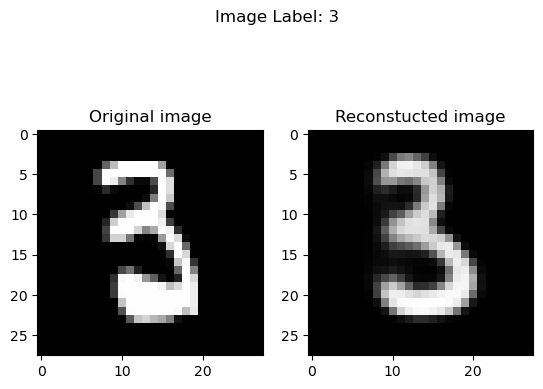

In [12]:
index=50025

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 9ms/step


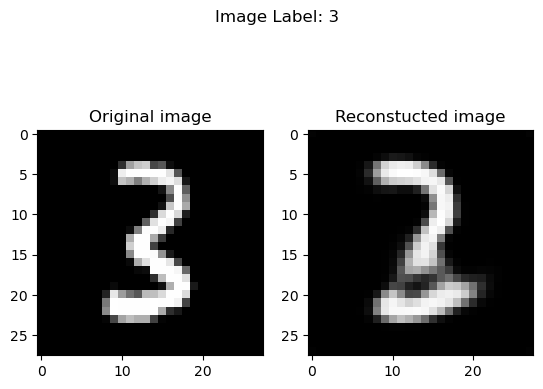

In [13]:
index=50000
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 4ms/step


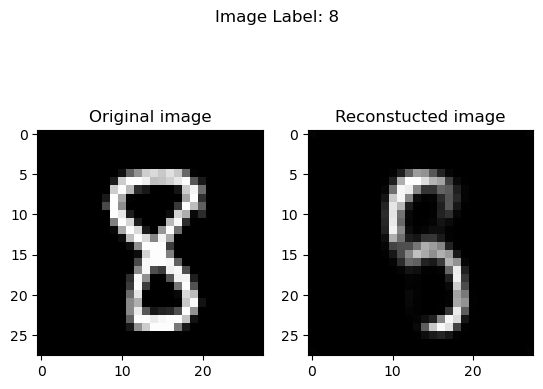

In [14]:
index=50001
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 14ms/step


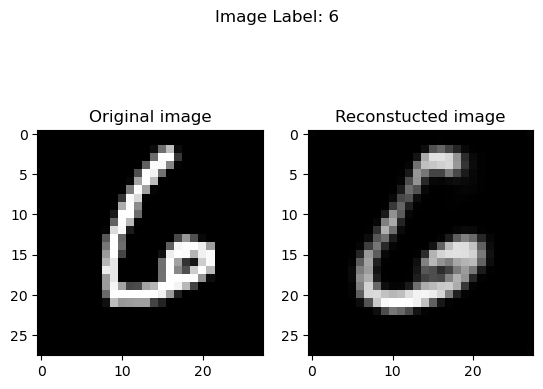

In [15]:
index=50002
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 6ms/step


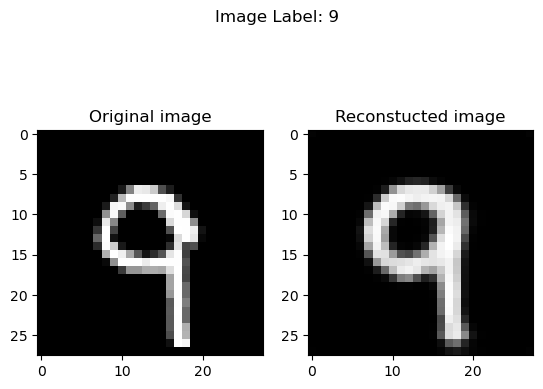

In [16]:
index=50003
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 12ms/step


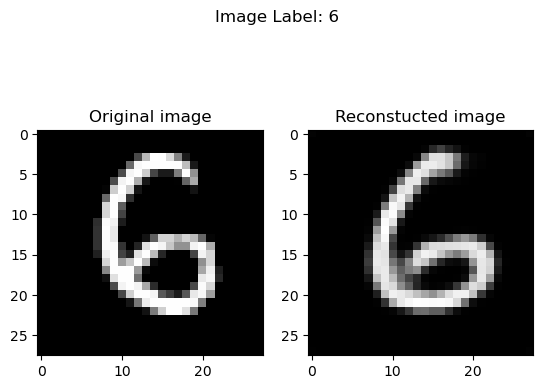

In [17]:
index=50004
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 12ms/step


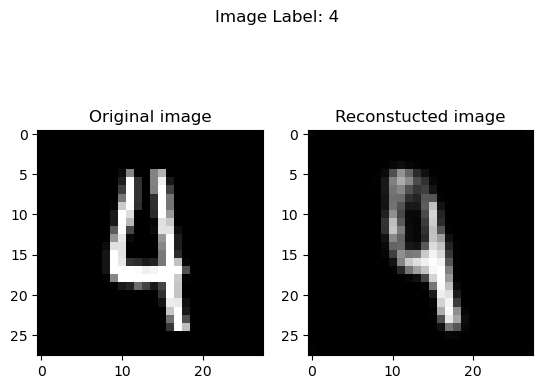

In [18]:
index=50005
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 4ms/step


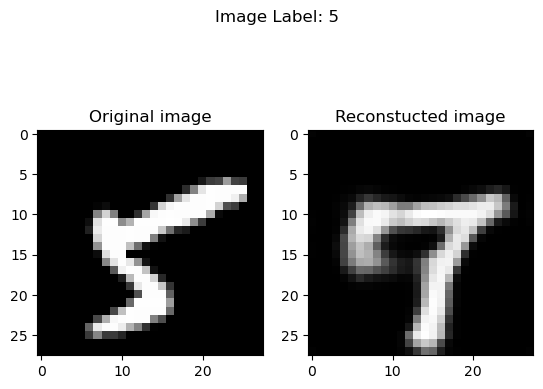

In [19]:
index=50006
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 12ms/step


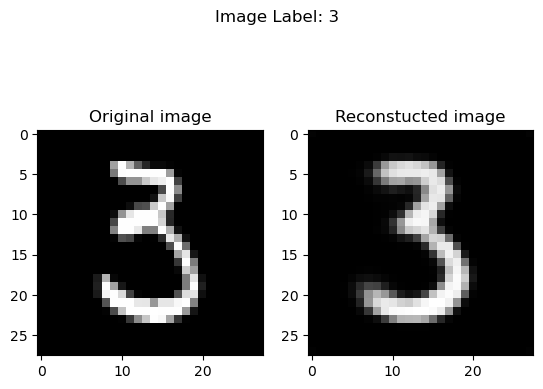

In [20]:
index=50007
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 12ms/step


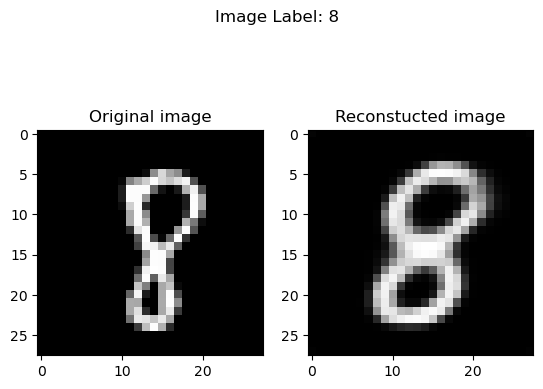

In [21]:
index=50008
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 10ms/step


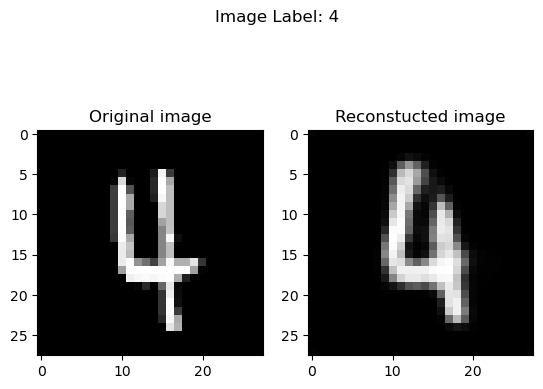

In [22]:
index=50009
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(mean, std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 7ms/step


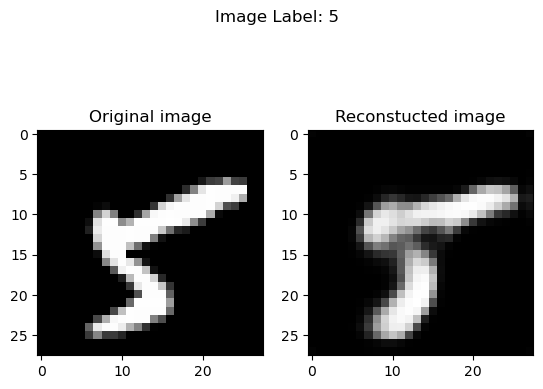

In [23]:
index=50006
mean, std = 0, 0.1

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(encoded_img.mean(), std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 12ms/step


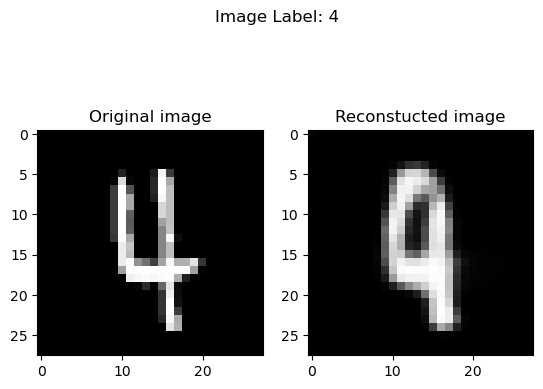

In [24]:
index=50009
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(encoded_img.mean(), std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 16ms/step


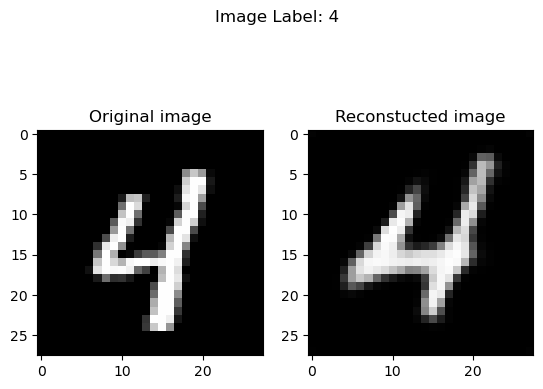

In [25]:
index=50050
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(encoded_img.mean(), std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 8ms/step


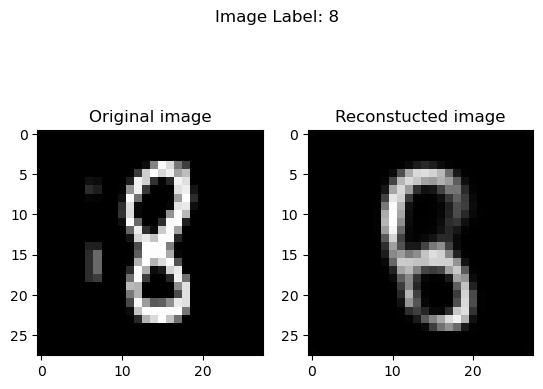

In [26]:
index=50035
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(encoded_img.mean(), std,size=encoded_img.shape)
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

1/1 [==============================] - 0s 20ms/step


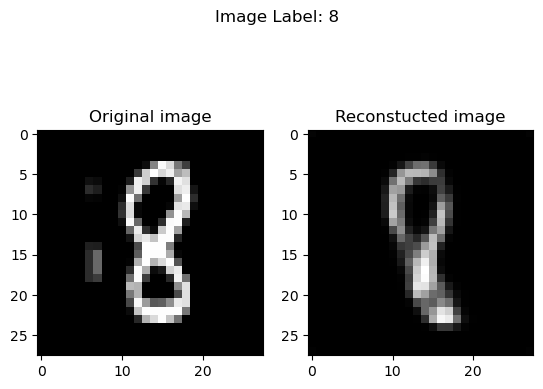

In [27]:
index=50035
mean, std = 0, 0.5

fig, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[index].reshape(ndim,ndim), cmap='gist_gray')
axarr[0].set_title("Original image")
encoded_out = vae.encoder.predict(np.array([x_train[index]]), verbose=0)
encoded_img = encoded_out[-1]
#print(encoded_img)
noise=np.random.normal(encoded_img.mean(), std,size=encoded_img.shape)*0.9
encoded_img+=noise
#print(encoded_img)
reconstructed_image = vae.decoder.predict(encoded_img)
axarr[1].imshow(reconstructed_image[0].reshape(ndim,ndim), cmap='gist_gray')
axarr[1].set_title("Reconstucted image")
fig.suptitle(f"Image Label: {y_train[index].argmax()}")
plt.show()

Text(0, 0.5, 'Train Loss')

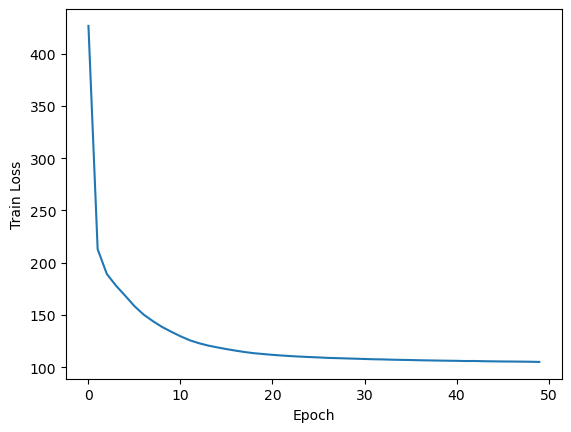

In [28]:
plt.plot(hist.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

Text(0, 0.5, 'Test Loss')

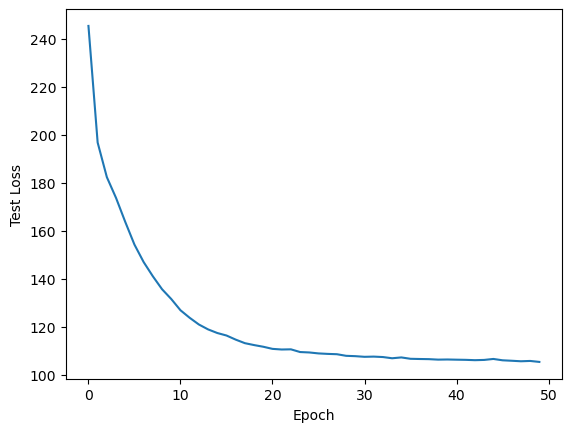

In [29]:
plt.plot(hist.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Test Loss")

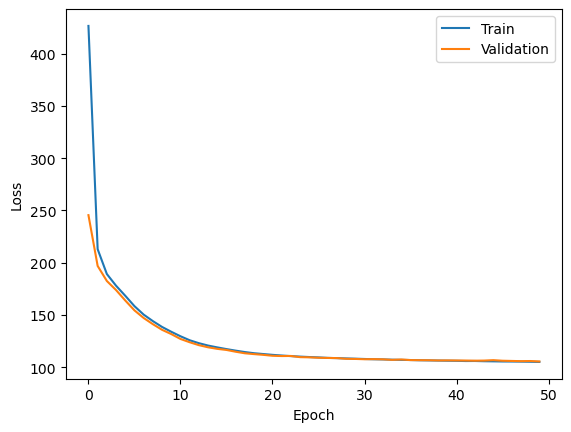

In [30]:
plt.plot(hist.history['loss'], label="Train")
plt.plot(hist.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

In [31]:
#encoder.save(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_encoder.h5")
#decoder.save(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_decoder.h5")
#encoder.save_weights(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_encoder_weights.h5")
#decoder.save_weights(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_decoder_weights.h5")
#vae.save_weights(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_vae_weights.h5")
vae.save_weights(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_vae_weights")
#tf.saved_model.save(vae, f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_vae")
#vae.save(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_vae.h5",save_format='tf')

In [10]:
#encoder_loaded=keras.models.load_model(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_encoder.h5")
#decoder_loaded=keras.models.load_model(f"drive/MyDrive/SSL/VAE/VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_decoder.h5")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(f"VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_vae_weights")

In [20]:
indices=np.load('digits_random_indices.npy')
indices_flattened=indices.flatten()

In [35]:
indices_flattened

array([59331, 55030, 53857, 58015, 54368, 57186, 52305, 55402, 56397,
       58510, 54210, 50477, 51033, 52317, 59958, 50652, 50855, 58056,
       57740, 52078, 52224, 56493, 50381, 58409, 59855, 59675, 54326,
       55525, 55559, 53390, 59408, 55881, 57227, 52432, 54767, 52022,
       58379, 57856, 53241, 52751, 59407, 52457, 50835, 50844, 54769,
       54007, 50889, 56331, 51270, 54447, 52947, 59064, 56898, 55349,
       50959, 52452, 57128, 51254, 56036, 58790, 58770, 53230, 55512,
       52100, 59907, 51507, 57514, 53220, 53331, 52957, 56028, 57365,
       51429, 58099, 54364, 56017, 50943, 57286, 52008, 56346, 59636,
       50996, 51160, 53653, 50762, 57513, 57411, 59838, 55741, 52980,
       59058, 55347, 56618, 56166, 51185, 58616, 50845, 54592, 52770,
       57545])

In [57]:
mean=0
std=0.5

In [58]:
encoded_imgs.shape

(100, 128)

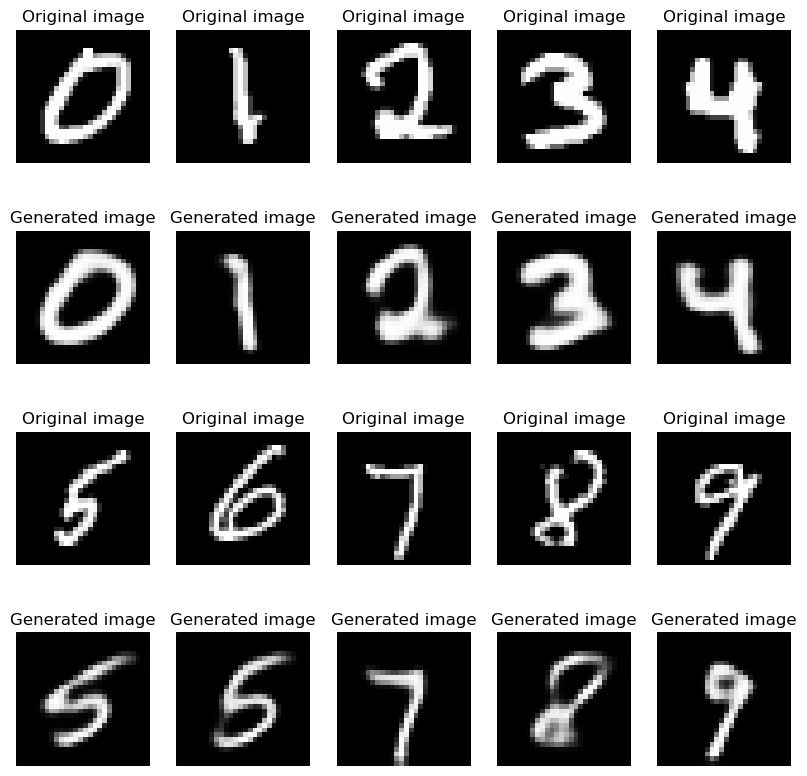

In [84]:
encoded_outs = vae.encoder.predict(x_train[indices_flattened], verbose=0)
encoded_imgs = encoded_outs[-1]
recons_imgs=np.zeros(x_train[indices_flattened].shape)
for i in range(100):
    noise=np.random.normal(mean,std,size=encoded_imgs[0].shape)
    noisy_latent=noise + encoded_imgs[i]
    new_img=vae.decoder.predict(np.array([noisy_latent]), verbose=0)
    recons_imgs[i, :] = new_img
"""noise=np.random.normal(mean,std,size=encoded_imgs.shape)
encoded_imgs+=noise
recons_imgs=vae.decoder.predict(encoded_imgs, verbose=0)"""

img_i=0
fig, axarr = plt.subplots(4,5, figsize=(10,10))
for i in range(2):
    for j in range(5):
        img=x_train[indices_flattened[img_i]]
        axarr[(i*2), j].imshow(img.reshape(ndim,ndim), cmap='gist_gray')
        axarr[(i*2), j].set_title("Original image")
        axarr[(i*2), j].set_axis_off()
        img=recons_imgs[img_i]
        axarr[(i*2)+1, j].imshow(img.reshape(ndim,ndim), cmap='gist_gray')
        axarr[(i*2)+1, j].set_title("Generated image")
        axarr[(i*2)+1, j].set_axis_off()
        img_i+=10

        
plt.show()

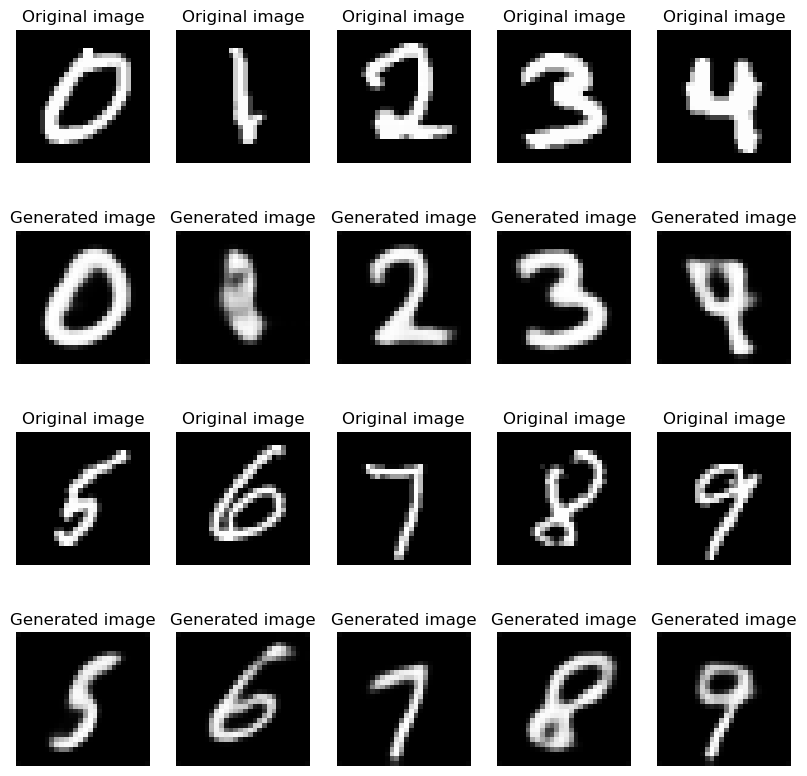

In [86]:
encoded_outs = vae.encoder.predict(x_train[indices_flattened], verbose=0)
encoded_imgs = encoded_outs[-1]
"""recons_imgs=np.zeros(x_train[indices_flattened].shape)
for i in range(100):
    noise=np.random.normal(mean,std,size=encoded_imgs[0].shape)
    noisy_latent=noise + encoded_imgs[i]
    new_img=vae.decoder.predict(np.array([noisy_latent]), verbose=0)
    recons_imgs[i, :] = new_img"""
noise=np.random.normal(mean,std,size=encoded_imgs.shape)
encoded_imgs+=noise
recons_imgs=vae.decoder.predict(encoded_imgs, verbose=0)

img_i=0
fig, axarr = plt.subplots(4,5, figsize=(10,10))
for i in range(2):
    for j in range(5):
        img=x_train[indices_flattened[img_i]]
        axarr[(i*2), j].imshow(img.reshape(ndim,ndim), cmap='gist_gray')
        axarr[(i*2), j].set_title("Original image")
        axarr[(i*2), j].set_axis_off()
        img=recons_imgs[img_i]
        axarr[(i*2)+1, j].imshow(img.reshape(ndim,ndim), cmap='gist_gray')
        axarr[(i*2)+1, j].set_title("Generated image")
        axarr[(i*2)+1, j].set_axis_off()
        img_i+=10

        
plt.show()